In [1]:
import pandas as pd
import json
import glob
import tqdm
import matplotlib.pyplot as plt
import numpy as np

import sklearn
import sklearn.metrics
import matplotlib
import scipy
import mplhep
import os
import awkward

import vector
import fastjet
import awkward as ak

import pandas
import boost_histogram as bh
import itertools
import mplhep

mplhep.set_style(mplhep.styles.CMS)

/tmp/ipykernel_2439880/2182789758.py:25: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  mplhep.set_style(mplhep.styles.CMS)


In [2]:
import sys

sys.path += ["../../mlpf/plotting//"]

import plot_utils
from plot_utils import pid_to_text, load_eval_data, compute_jet_ratio, compute_met_and_ratio

from plot_utils import cms_label, sample_label
from plot_utils import ELEM_LABELS_CMS, ELEM_NAMES_CMS
from plot_utils import CLASS_LABELS_CMS, CLASS_NAMES_CMS

In [3]:
def compute_met_and_ratio(yvals):
    msk = yvals["target_cls_id"] != 0
    gen_px = yvals["target_px"][msk]
    gen_py = yvals["target_py"][msk]

    msk_pred = yvals["pred_cls_id"] != 0
    pred_px = yvals["pred_px"][msk]
    pred_py = yvals["pred_py"][msk]
    
    msk_cand = yvals["cand_cls_id"] != 0
    cand_px = yvals["cand_px"][msk]
    cand_py = yvals["cand_py"][msk]

    gen_met = ak.to_numpy(np.sqrt(np.sum(gen_px, axis=1) ** 2 + np.sum(gen_py, axis=1) ** 2))
    pred_met = ak.to_numpy(np.sqrt(np.sum(pred_px, axis=1) ** 2 + np.sum(pred_py, axis=1) ** 2))
    cand_met = ak.to_numpy(np.sqrt(np.sum(cand_px, axis=1) ** 2 + np.sum(cand_py, axis=1) ** 2))

    met_ratio_pred = ak.to_numpy(pred_met / gen_met)
    met_ratio_cand = ak.to_numpy(cand_met / gen_met)

    return {
        "gen_met": gen_met,
        "pred_met": pred_met,
        "cand_met": cand_met,
        "ratio_pred": met_ratio_pred,
        "ratio_cand": met_ratio_cand,
    }


def sum_overflow_into_last_bin(all_values):
    values = all_values[1:-1]
    values[-1] = values[-1] + all_values[-1]
    values[0] = values[0] + all_values[0]
    return values


def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    h1[:] = sum_overflow_into_last_bin(h1.values(flow=True)[:])
    return h1


def loss_plot(epochs, train, test, margin=0.05, smoothing=False):
    fig = plt.figure()
    ax = plt.axes()

    alpha = 0.2 if smoothing else 1.0
    l0 = None if smoothing else "train"
    l1 = None if smoothing else "test"
    p0 = plt.plot(epochs, train, alpha=alpha, label=l0)
    p1 = plt.plot(epochs, test, alpha=alpha, label=l1)

    if smoothing:
        train_smooth = np.convolve(train, np.ones(5) / 5, mode="valid")
        plt.plot(epochs, train_smooth, color=p0[0].get_color(), lw=2, label="train")
        test_smooth = np.convolve(test, np.ones(5) / 5, mode="valid")
        plt.plot(epochs, test_smooth, color=p1[0].get_color(), lw=2, label="test")

    plt.ylim(test[-1] * (1.0 - margin), test[-1] * (1.0 + margin))
    plt.legend(loc=3, frameon=False)
    plt.xlabel("epoch")
    cms_label(ax)


def med_iqr(arr):
    p25 = np.percentile(arr, 25)
    p50 = np.percentile(arr, 50)
    p75 = np.percentile(arr, 75)
    return p50, p75 - p25

def midpoints(x):
    return (x[1:] + x[:-1]) / 2

def flatten(arr):
    return arr.reshape(-1, arr.shape[-1])


def get_distribution(prefix, bins, var):

    hists = []
    for pid in [13, 11, 22, 1, 2, 130, 211]:
        icls = CLASS_LABELS_CMS.index(pid)
        msk_pid = yvals_f[prefix + "_cls_id"] == icls
        h = bh.Histogram(bh.axis.Variable(bins))
        d = yvals_f[prefix + "_" + var][msk_pid]
        h.fill(d.flatten())
        hists.append(h)
    return hists


def binom_error(n_sig, n_tot):
    """
    for an efficiency = nSig/nTrueSig or purity = nSig / (nSig + nBckgrd), this function calculates the
    standard deviation according to http://arxiv.org/abs/physics/0701199 .
    """
    variance = np.where(
        n_tot > 0, (n_sig + 1) * (n_sig + 2) / ((n_tot + 2) * (n_tot + 3)) - (n_sig + 1) ** 2 / ((n_tot + 2) ** 2), 0
    )
    return np.sqrt(variance)


def reso_plot(pid, var, bins, ptcl_name):

    fig = plt.figure()
    ax = plt.axes()

    msk = (yvals_ttbar["target_cls_id"] == pid) & (yvals_ttbar["cand_cls_id"] != 0) & (yvals_ttbar["pred_cls_id"] != 0)
    vals_gen = awkward.flatten(yvals_ttbar["target_" + var][msk])
    vals_cand = awkward.flatten(yvals_ttbar["cand_" + var][msk])
    vals_mlpf = awkward.flatten(yvals_ttbar["pred_" + var][msk])

    reso_1 = vals_cand / vals_gen
    reso_2 = vals_mlpf / vals_gen
    plt.hist(reso_1, bins=bins, histtype="step", lw=2, label="PF, M={:.2f}, IQR={:.2f}".format(*med_iqr(reso_1)))
    plt.hist(reso_2, bins=bins, histtype="step", lw=2, label="MLPF, M={:.2f}, IQR={:.2f}".format(*med_iqr(reso_2)))
    plt.yscale("log")
    if var == "pt":
        plt.xlabel(r"$p_\mathrm{T,reco} / p_\mathrm{T,gen}$")
    elif var == "eta":
        plt.xlabel(r"$\eta_\mathrm{reco} / \eta_\mathrm{gen}$")
    plt.ylabel("Number of particles / bin")
    cms_label(ax)
    sample_label(ax, "cms_pf_ttbar", ptcl_name)
    plt.xlim(min(bins), max(bins))
    plt.legend(loc=(0.4, 0.7))
    plt.savefig("{}/{}_res_{}.pdf".format(outpath, var, pid), bbox_inches="tight")


def plot_eff_and_fake_rate(icls=1, ivar=4, ielem=1, bins=np.linspace(-3, 6, 100), xlabel="PFElement log[E/GeV]", log=True):

    values = X_ttbar[:, :, ivar]

    hist_X = bh.Histogram(bh.axis.Variable(bins))
    hist_gen = bh.Histogram(bh.axis.Variable(bins))
    hist_gen_pred = bh.Histogram(bh.axis.Variable(bins))
    hist_gen_cand = bh.Histogram(bh.axis.Variable(bins))
    hist_pred = bh.Histogram(bh.axis.Variable(bins))
    hist_cand = bh.Histogram(bh.axis.Variable(bins))
    hist_pred_fake = bh.Histogram(bh.axis.Variable(bins))
    hist_cand_fake = bh.Histogram(bh.axis.Variable(bins))

    eff_mlpf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())
    eff_pf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())
    fake_pf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())
    fake_mlpf = bh.Histogram(bh.axis.Variable(bins), storage=bh.storage.Weight())

    if ielem == 45:
        msk_X = (X_ttbar[:, :, 0] == 4) | (X_ttbar[:, :, 0] == 5)
    else:
        msk_X = X_ttbar[:, :, 0] == ielem

    msk_gen = yvals_ttbar["target_cls_id"] == icls
    msk_nogen = yvals_ttbar["target_cls_id"] != icls

    msk_pred = yvals_ttbar["pred_cls_id"] == icls
    msk_nopred = yvals_ttbar["pred_cls_id"] != icls

    msk_cand = yvals_ttbar["cand_cls_id"] == icls
    msk_nocand = yvals_ttbar["cand_cls_id"] != icls

    hist_X.fill(awkward.flatten(values[msk_X]))
    hist_gen.fill(awkward.flatten(values[msk_gen & msk_X]))
    hist_pred.fill(awkward.flatten(values[msk_pred & msk_X]))
    hist_cand.fill(awkward.flatten(values[msk_cand & msk_X]))

    # Genparticle exists, reco particle exists
    hist_gen_pred.fill(awkward.flatten(values[msk_gen & msk_pred & msk_X]))
    hist_gen_cand.fill(awkward.flatten(values[msk_gen & msk_cand & msk_X]))

    # Genparticle does not exist, reco particle exists
    hist_pred_fake.fill(awkward.flatten(values[msk_nogen & msk_pred & msk_X]))
    hist_cand_fake.fill(awkward.flatten(values[msk_nogen & msk_cand & msk_X]))

    eff_mlpf.values()[:] = hist_gen_pred.values() / hist_gen.values()
    eff_mlpf.variances()[:] = binom_error(hist_gen_pred.values(), hist_gen.values()) ** 2

    eff_pf.values()[:] = hist_gen_cand.values() / hist_gen.values()
    eff_pf.variances()[:] = binom_error(hist_gen_cand.values(), hist_gen.values()) ** 2

    fake_pf.values()[:] = hist_cand_fake.values() / hist_cand.values()
    fake_pf.variances()[:] = binom_error(hist_cand_fake.values(), hist_cand.values()) ** 2

    fake_mlpf.values()[:] = hist_pred_fake.values() / hist_pred.values()
    fake_mlpf.variances()[:] = binom_error(hist_pred_fake.values(), hist_pred.values()) ** 2

    plt.figure()
    ax = plt.axes()
    mplhep.histplot(hist_X, label="all PFElements", color="black")
    mplhep.histplot(hist_cand, label="with PF")
    mplhep.histplot(hist_pred, label="with MLPF reco")
    mplhep.histplot(hist_gen, label="with MLPF truth")
    plt.ylabel("Number of PFElements / bin")
    plt.xlabel(xlabel)
    plt.yscale("log")
    cms_label(ax)
    sample_label(ax, "cms_pf_ttbar", ", " + CLASS_NAMES_CMS[icls])
    if log:
        plt.xscale("log")
    plt.legend(loc=(0.6, 0.65))
    plt.ylim(10, 20 * np.max(hist_X.values()))
    plt.xlim(min(bins), max(bins))
    plt.savefig("{}/distr_icls{}_ivar{}.pdf".format(outpath, icls, ivar), bbox_inches="tight")

    plt.figure()
    ax = plt.axes(sharex=ax)
    mplhep.histplot(eff_pf, label="PF")
    mplhep.histplot(eff_mlpf, label="MLPF")
    plt.ylim(0, 1.5)
    plt.ylabel("Efficiency")
    plt.xlabel(xlabel)
    cms_label(ax)
    sample_label(ax, "cms_pf_ttbar", ", " + CLASS_NAMES_CMS[icls])
    if log:
        plt.xscale("log")
    plt.legend(loc=(0.75, 0.7))
    plt.xlim(min(bins), max(bins))
    plt.savefig("{}/eff_icls{}_ivar{}.pdf".format(outpath, icls, ivar), bbox_inches="tight")

    plt.figure()
    ax = plt.axes(sharex=ax)
    mplhep.histplot(fake_pf, label="PF")
    mplhep.histplot(fake_mlpf, label="MLPF")
    plt.ylim(0, 1.5)
    plt.ylabel("Fake rate")
    plt.xlabel(xlabel)
    cms_label(ax)
    sample_label(ax, "cms_pf_ttbar", ", " + CLASS_NAMES_CMS[icls])
    if log:
        plt.xscale("log")
    plt.legend(loc=(0.75, 0.7))
    plt.xlim(min(bins), max(bins))
    plt.savefig("{}/fake_icls{}_ivar{}.pdf".format(outpath, icls, ivar), bbox_inches="tight")

    # mplhep.histplot(fake, bins=hist_gen[1], label="fake rate", color="red")


#     plt.legend(frameon=False)
#     plt.ylim(0,1.4)
#     plt.xlabel(xlabel)
#     plt.ylabel("Fraction of particles / bin")

In [7]:
path = "/scratch/persistent/joosep/huggingface/particleflow/cms/v2.3.0/pyg-cms_20250122_185427_365548/preds_checkpoint-10-3.541986/"
PAPERMILL_OUTPUT_PATH = "./"

In [8]:
outpath = PAPERMILL_OUTPUT_PATH
if os.path.isfile(outpath):
    outpath = os.path.dirname(outpath)
print("params", path, outpath)

params /scratch/persistent/joosep/huggingface/particleflow/cms/v2.3.0/pyg-cms_20250122_185427_365548/preds_checkpoint-10-3.541986/ ./


# Load the predictions

In [9]:
yvals_qcd, X_qcd, _ = load_eval_data(f"{path}/cms_pf_qcd/*.parquet", 100)

path /scratch/persistent/joosep/huggingface/particleflow/cms/v2.3.0/pyg-cms_20250122_185427_365548/preds_checkpoint-10-3.541986//cms_pf_qcd/*.parquet


Loading eval data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.37it/s]


In [99]:
yvals_ttbar, X_ttbar, _ = load_eval_data(f"{path}/cms_pf_ttbar/*.parquet", 1000)

path /scratch/persistent/joosep/huggingface/particleflow/cms/v2.3.0/pyg-cms_20250122_185427_365548/preds_checkpoint-10-3.541986//cms_pf_ttbar/*.parquet


Loading eval data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.44it/s]


In [ ]:
# ptbins = np.logspace(-3,3,20)

# meds_mlpf = []
# iqr_over_med_mlpf = []

# meds_pf = []
# iqr_over_med_pf = []

# for ibin in range(len(ptbins)-1):
#     plt.figure(figsize=(8, 8))
#     b = np.logspace(-5, 5, 61)

#     msk = (yvals_qcd["target_cls_id"]!=0) & (yvals_qcd["cand_cls_id"]!=0) & (yvals_qcd["target_pt"]>ptbins[ibin]) & (yvals_qcd["target_pt"]<ptbins[ibin+1])
#     if np.sum(msk)>10:
#         pt_ratio = awkward.flatten((yvals_qcd["cand_pt"]/yvals_qcd["target_pt"])[msk])
#         plt.hist(pt_ratio, bins=b, histtype="step", label="PF");
#         med, iqr = med_iqr(pt_ratio)
#     else:
#         med, iqr = 1, 0
#     meds_pf.append(med)
#     iqr_over_med_pf.append(iqr/med)
    
#     msk = (yvals_qcd["target_cls_id"]!=0) & (yvals_qcd["pred_cls_id"]!=0) & (yvals_qcd["target_pt"]>ptbins[ibin]) & (yvals_qcd["target_pt"]<ptbins[ibin+1])
#     if np.sum(msk)>10:
#         pt_ratio = awkward.flatten((yvals_qcd["pred_pt"]/yvals_qcd["target_pt"])[msk])
#         plt.hist(pt_ratio, bins=b, histtype="step", label="MLPF");
#         med, iqr = med_iqr(pt_ratio)
#     else:
#         med, iqr = 1, 0
#     meds_mlpf.append(med)
#     iqr_over_med_mlpf.append(iqr/med)

#     plt.xscale("log")
#     plt.title("$p_{{T,target}} \in $[{:.2E}, {:.2E}]".format(ptbins[ibin], ptbins[ibin+1]))
#     plt.xlabel("response $p_{{T,pred}}/p_{{T,target}}$")
#     plt.ylabel("particles / bin")
#     plt.legend()

In [ ]:
# msk = (yvals_qcd["target_cls_id"]!=0) & (yvals_qcd["pred_cls_id"]!=0)
# b = np.logspace(-3, 3, 100)
# plt.figure(figsize=(5,5))
# plt.hist(awkward.flatten(yvals_qcd["target_pt"][msk]), bins=b, density=1);
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("Particle $p_T$")
# plt.ylabel("Particles [a.u.]")

In [ ]:
# plt.figure(figsize=(5,5))
# plt.plot(midpoints(ptbins), meds_pf, marker="o", label="PF")
# plt.plot(midpoints(ptbins), meds_mlpf, marker="o", label="MLPF")
# #plt.ylim(0, 10)
# plt.axhline(1.0, color="black")
# plt.yscale("log")
# plt.xscale("log")
# plt.xlabel("Particle $p_T$")
# plt.ylabel("med. of $p_T$ response")
# plt.legend(loc="best")

In [ ]:
# plt.figure(figsize=(5,5))
# plt.plot(midpoints(ptbins), iqr_over_med_pf, marker="o", label="PF")
# plt.plot(midpoints(ptbins), iqr_over_med_mlpf, marker="o", label="MLPF")
# #plt.ylim(0, 5)
# plt.xscale("log")
# plt.xlabel("Particle $p_T$ [GeV]")
# plt.ylabel("IQR/med. of $p_T$ response")
# plt.legend()

In [ ]:
# plt.figure(figsize=(5,5))

# plt.scatter(
#     awkward.sum(yvals_qcd["target_cls_id"]!=0, axis=1),
#     awkward.sum(yvals_qcd["cand_cls_id"]!=0, axis=1),
#     label="PF", marker=".", alpha=0.2
# )

# plt.scatter(
#     awkward.sum(yvals_qcd["target_cls_id"]!=0, axis=1),
#     awkward.sum(yvals_qcd["pred_cls_id"]!=0, axis=1),
#     label="MLPF", marker="^", alpha=0.2
# )
# plt.xlabel("Target particles")
# plt.ylabel("Reco particles")
# plt.legend(loc="best")
# plt.plot([1500,5000],[1500,5000], color="black", ls="--")
# plt.show()

In [ ]:
# plt.figure(figsize=(5,5))

# plt.scatter(
#     awkward.sum(yvals_qcd["target_energy"], axis=1),
#     awkward.sum(yvals_qcd["cand_energy"], axis=1),
#     label="PF", marker=".", alpha=0.2
# )

# plt.scatter(
#     awkward.sum(yvals_qcd["target_energy"], axis=1),
#     awkward.sum(yvals_qcd["pred_energy"], axis=1),
#     label="MLPF", marker="^", alpha=0.2
# )

# #plt.xlabel("Target particles")
# #plt.ylabel("Reconstructed particles")
# plt.legend(loc="best")
# plt.plot([20000,100000],[20000,100000], color="black", ls="--")
# plt.xlabel("Total target energy [GeV]")
# plt.ylabel("Total reco energy [GeV]")
# plt.show()

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(10,5))

# plt.sca(ax[0])
# typ = 5
# msk = (X_qcd[..., 0]==typ) & (yvals_qcd["target_cls_id"]!=0)
# b = np.logspace(-1,3,100)
# plt.hist2d(
#     awkward.to_numpy(awkward.flatten(yvals_qcd["target_energy"][msk])),
#     awkward.to_numpy(awkward.flatten(yvals_qcd["pred_energy"][msk])),
#     bins = (b,b), cmap="Blues"
# )
# plt.plot([1e-1, 1e3], [1e-1,1e3], color="black", ls="--")
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel("target energy")
# plt.ylabel("reconstructed energy")

# plt.sca(ax[1])
# b = np.linspace(-5,5,100)
# plt.hist(np.log(awkward.to_numpy(awkward.flatten(X_qcd[..., 5][msk]/yvals_qcd["target_energy"][msk]))), bins=b, histtype="step", lw=1, label="PFElement")
# plt.hist(np.log(awkward.to_numpy(awkward.flatten(yvals_qcd["cand_energy"][msk]/yvals_qcd["target_energy"][msk]))), bins=b, histtype="step", lw=1, label="PF")
# plt.hist(np.log(awkward.to_numpy(awkward.flatten(yvals_qcd["pred_energy"][msk]/yvals_qcd["target_energy"][msk]))), bins=b, histtype="step", lw=1, label="MLPF")
# plt.yscale("log")
# plt.xlabel("log [E / E_target]")
# plt.legend(loc=2)

# plt.suptitle(ELEM_NAMES_CMS[ELEM_LABELS_CMS.index(typ)])

# plt.show()

In [ ]:
iev = 0
plt.figure()
plt.scatter(
    yvals_qcd["target_eta"][yvals_qcd["target_cls_id"]!=0][iev],
    yvals_qcd["target_phi"][yvals_qcd["target_cls_id"]!=0][iev],
    s = yvals_qcd["target_pt"][yvals_qcd["target_cls_id"]!=0][iev]
)

# plt.scatter(
#     yvals_qcd["cand_eta"][yvals_qcd["cand_cls_id"]!=0][iev],
#     yvals_qcd["cand_phi"][yvals_qcd["cand_cls_id"]!=0][iev],
#     s = yvals_qcd["cand_pt"][yvals_qcd["cand_cls_id"]!=0][iev]
# )

plt.scatter(
    yvals_qcd["pred_eta"][yvals_qcd["pred_cls_id"]!=0][iev],
    yvals_qcd["pred_phi"][yvals_qcd["pred_cls_id"]!=0][iev],
    s = yvals_qcd["pred_pt"][yvals_qcd["pred_cls_id"]!=0][iev]
)
plt.xlim(-6,6)
plt.ylim(-4,4)
plt.show()

In [ ]:
b = np.linspace(-5,5,101)
plt.figure()
plt.hist(awkward.flatten(yvals_qcd["target_eta"][yvals_qcd["target_cls_id"]!=0]), bins=b, histtype="step");
plt.hist(awkward.flatten(yvals_qcd["pred_eta"][yvals_qcd["pred_cls_id"]!=0]), bins=b, histtype="step");
plt.show()

In [ ]:
b = np.linspace(-5,5,61)
plt.figure()
plt.hist(awkward.flatten(yvals_qcd["target_eta"][yvals_qcd["target_cls_id"]!=0]), bins=b, histtype="step", weights=awkward.flatten(yvals_qcd["target_pt"][yvals_qcd["target_cls_id"]!=0]));
plt.hist(awkward.flatten(yvals_qcd["pred_eta"][yvals_qcd["pred_cls_id"]!=0]), bins=b, histtype="step", weights=awkward.flatten(yvals_qcd["pred_pt"][yvals_qcd["pred_cls_id"]!=0]));
plt.show()

In [ ]:
cls_id = 2

plt.figure()
l = plt.hist(
    ak.flatten(yvals_qcd["target_pt"][yvals_qcd["target_cls_id"]==cls_id]),
    bins=np.logspace(-3,4,100), histtype="step", lw=2, label="qcd target"
);

plt.hist(
    ak.flatten(yvals_qcd["pred_pt"][yvals_qcd["pred_cls_id"]==cls_id]),
    bins=np.logspace(-3,4,100), histtype="step", lw=2, label="qcd MLPF", color=l[2][0].get_edgecolor(), ls="--"
);
plt.hist(
    ak.flatten(yvals_qcd["cand_pt"][yvals_qcd["cand_cls_id"]==cls_id]),
    bins=np.logspace(-3,4,100), histtype="step", lw=1, label="qcd PF", color=l[2][0].get_edgecolor(), ls="--"
);


# l = plt.hist(
#     ak.flatten(yvals_ttbar["gen_pt"][yvals_ttbar["gen_cls_id"]==cls_id]),
#     bins=np.logspace(-3,4,100), histtype="step", lw=2, label="tt gen"
# );

# plt.hist(
#     ak.flatten(yvals_ttbar["pred_pt"][yvals_ttbar["pred_cls_id"]==cls_id]),
#     bins=np.logspace(-3,4,100), histtype="step", lw=2, label="tt MLPF", color=l[2][0].get_edgecolor(), ls="--"
# );

# plt.hist(
#     ak.flatten(yvals_ttbar["cand_pt"][yvals_ttbar["cand_cls_id"]==cls_id]),
#     bins=np.logspace(-3,4,100), histtype="step", lw=1, label="tt PF", color=l[2][0].get_edgecolor(), ls="--"
# );

plt.legend(loc="best")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
x_all = ak.to_numpy(ak.flatten(X_qcd[(X_qcd[:, :, 0]==4)][:, :, 5]))
x_with_gen = ak.to_numpy(ak.flatten(X_qcd[(X_qcd[:, :, 0]==4) & (yvals_qcd["target_cls_id"]!=0)][:, :, 5]))
x_with_cand = ak.to_numpy(ak.flatten(X_qcd[(X_qcd[:, :, 0]==4) & (yvals_qcd["cand_cls_id"]!=0)][:, :, 5]))
x_with_pred = ak.to_numpy(ak.flatten(X_qcd[(X_qcd[:, :, 0]==4) & (yvals_qcd["pred_cls_id"]!=0)][:, :, 5]))

In [ ]:
h_all = to_bh(x_all, np.logspace(-0.8,4,100))
h_with_gen = to_bh(x_with_gen, np.logspace(-0.8,4,100))
h_with_cand = to_bh(x_with_cand, np.logspace(-0.8,4,100))
h_with_pred = to_bh(x_with_pred, np.logspace(-0.8,4,100))

In [ ]:
plt.figure()
mplhep.histplot(h_all);
mplhep.histplot(h_with_gen);
mplhep.histplot(h_with_cand);
mplhep.histplot(h_with_pred);
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
gen_pt = ak.to_numpy(ak.flatten(yvals_qcd["target_pt"][(X_qcd[:, :, 0]==4) & (yvals_qcd["target_cls_id"]!=0)]))
pred_pt = ak.to_numpy(ak.flatten(yvals_qcd["pred_pt"][(X_qcd[:, :, 0]==4) & (yvals_qcd["target_cls_id"]!=0)]))
cand_pt = ak.to_numpy(ak.flatten(yvals_qcd["cand_pt"][(X_qcd[:, :, 0]==4) & (yvals_qcd["target_cls_id"]!=0)]))

In [ ]:
msk = (X_qcd[:, :, 0]==4) & (yvals_qcd["target_cls_id"]!=0) & (yvals_qcd["cand_cls_id"]!=0) & (yvals_qcd["pred_cls_id"]!=0)
gen_pt = ak.to_numpy(ak.flatten(yvals_qcd["target_energy"][msk]))
pred_pt = ak.to_numpy(ak.flatten(yvals_qcd["pred_energy"][msk]))
cand_pt = ak.to_numpy(ak.flatten(yvals_qcd["cand_energy"][msk]))

plt.figure()
bins = np.logspace(-1,3,100)
plt.hist(gen_pt, bins=bins, histtype="step", lw=2);
plt.hist(cand_pt, bins=bins, histtype="step", lw=2);
plt.hist(pred_pt, bins=bins, histtype="step", lw=2);
plt.yscale("log")
plt.xscale("log")

plt.figure()
plt.hist2d(gen_pt, cand_pt, bins);
plt.yscale("log")
plt.xscale("log")

plt.figure()
plt.hist2d(gen_pt, pred_pt, bins);
plt.yscale("log")
plt.xscale("log")

In [ ]:
msk = (X_qcd[:, :, 0]==4) & (yvals_qcd["target_cls_id"]!=0)
gen_pt = ak.to_numpy(ak.flatten(X_qcd[msk][:, :, 5]))
msk = (X_qcd[:, :, 0]==4) & (yvals_qcd["pred_cls_id"]!=0)
pred_pt = ak.to_numpy(ak.flatten(X_qcd[msk][:, :, 5]))
msk = (X_qcd[:, :, 0]==4) & (yvals_qcd["cand_cls_id"]!=0)
cand_pt = ak.to_numpy(ak.flatten(X_qcd[msk][:, :, 5]))

plt.figure()
plt.hist(gen_pt, bins=np.logspace(-1,3,100), histtype="step", lw=2);
plt.hist(cand_pt, bins=np.logspace(-1,3,100), histtype="step", lw=2);
plt.hist(pred_pt, bins=np.logspace(-1,3,100), histtype="step", lw=2);
plt.xscale("log")
plt.yscale("log")

In [ ]:
msk = (X_qcd[:, :, 0]==4) & (yvals_qcd["target_cls_id"]!=0) & (yvals_qcd["cand_cls_id"]!=0) & (yvals_qcd["pred_cls_id"]!=0)
gen_pt = ak.to_numpy(ak.flatten(yvals_qcd["target_pt"][msk]))
pred_pt = ak.to_numpy(ak.flatten(yvals_qcd["pred_pt"][msk]))
cand_pt = ak.to_numpy(ak.flatten(yvals_qcd["cand_pt"][msk]))

plt.figure()
plt.hist(gen_pt, bins=np.logspace(-1,3,100), histtype="step", lw=2);
plt.hist(cand_pt, bins=np.logspace(-1,3,100), histtype="step", lw=2);
plt.hist(pred_pt, bins=np.logspace(-1,3,100), histtype="step", lw=2);
plt.xscale("log")
plt.yscale("log")

plt.figure()
plt.hist2d(gen_pt, cand_pt, np.logspace(-1,3,100));
plt.xscale('log')
plt.yscale('log')

plt.figure()
plt.hist2d(gen_pt, pred_pt, np.logspace(-1,3,100));
plt.xscale('log')
plt.yscale('log')

In [ ]:
msk = yvals_qcd["target_cls_id"]!=0
plt.hist(np.log(ak.flatten(yvals_qcd["target_energy"][msk]/X_qcd[msk][:, :, 5])), bins=np.linspace(-10,10,100));
plt.yscale("log")

### Full distribution plots for each class

In [ ]:
met_and_ratio = compute_met_and_ratio(yvals_ttbar)

In [ ]:
for icls in range(0, 8):
    fig, axs = plt.subplots(
        2, 2, figsize=(2 * mplhep.styles.CMS["figure.figsize"][0], 2 * mplhep.styles.CMS["figure.figsize"][1])
    )

    for ax, ivar in zip(axs.flatten(), ["pt", "energy", "eta", "phi"]):

        plt.sca(ax)

        if icls == 0:
            vals_true = awkward.flatten(yvals_ttbar["target_" + ivar][yvals_ttbar["target_cls_id"] != 0])
            vals_pf = awkward.flatten(yvals_ttbar["cand_" + ivar][yvals_ttbar["cand_cls_id"] != 0])
            vals_pred = awkward.flatten(yvals_ttbar["pred_" + ivar][yvals_ttbar["pred_cls_id"] != 0])
        else:
            vals_true = awkward.flatten(yvals_ttbar["target_" + ivar][yvals_ttbar["target_cls_id"] == icls])
            vals_pf = awkward.flatten(yvals_ttbar["cand_" + ivar][yvals_ttbar["cand_cls_id"] == icls])
            vals_pred = awkward.flatten(yvals_ttbar["pred_" + ivar][yvals_ttbar["pred_cls_id"] == icls])

        if ivar == "pt" or ivar == "energy":
            b = np.logspace(-3, 4, 61)
            log = True
        else:
            b = np.linspace(np.min(vals_true), np.max(vals_true), 41)
            log = False

        plt.hist(vals_true, bins=b, histtype="step", lw=2, label="gen", color="black")
        plt.hist(vals_pf, bins=b, histtype="step", lw=2, label="PF")
        plt.hist(vals_pred, bins=b, histtype="step", lw=2, label="MLPF")
        plt.legend(loc=(0.75, 0.75))

        ylim = ax.get_ylim()

        cls_name = CLASS_NAMES_CMS[icls] if icls > 0 else "all"
        plt.xlabel("{} {}".format(cls_name, ivar))

        plt.yscale("log")
        plt.ylim(10, 10 * ylim[1])

        if log:
            plt.xscale("log")
        cms_label(ax)

    # plt.tight_layout()
    #plt.savefig("{}/distribution_icls{}.pdf".format(outpath, icls), bbox_inches="tight")

### Plot of the neutral cluster classification output

In [ ]:
X = X_qcd
yvals = yvals_qcd
physics_process = "cms_pf_qcd"

In [ ]:
df = pandas.DataFrame()
msk = X[:, :, 0] == 5
df["X_energy"] = awkward.to_numpy(awkward.flatten(X[msk][:, :, 5]))
df["X_eta"] = awkward.to_numpy(awkward.flatten(X[msk][:, :, 2]))

df["cand_energy"] = awkward.to_numpy(awkward.flatten(yvals["cand_energy"][msk]))
df["cand_cls_id"] = awkward.to_numpy(awkward.flatten(yvals["cand_cls_id"][msk]))

df["target_energy"] = awkward.to_numpy(awkward.flatten(yvals["target_energy"][msk]))
df["target_cls_id"] = awkward.to_numpy(awkward.flatten(yvals["target_cls_id"][msk]))

df["pred_energy"] = awkward.to_numpy(awkward.flatten(yvals["pred_energy"][msk]))
df["pred_cls_id"] = awkward.to_numpy(awkward.flatten(yvals["pred_cls_id"][msk]))

In [ ]:
b = np.logspace(-2,3,100)
plt.hist(df["X_energy"][(df["pred_energy"]==0) & (df["cand_energy"]==0) & (df["target_energy"]>0)], bins=b, histtype="step", lw=2);
plt.hist(df["X_energy"][(df["pred_energy"]==0) & (df["cand_energy"]>0) & (df["target_energy"]>0)], bins=b, histtype="step", lw=2);
plt.hist(df["X_energy"][(df["pred_energy"]>0) & (df["cand_energy"]==0) & (df["target_energy"]>0)], bins=b, histtype="step", lw=2);
#plt.hist(df["X_energy"][(df["cand_energy"]==0) & (df["gen_energy"]>0)], bins=b);
plt.xscale("log")

In [ ]:
b = np.linspace(0, 1, 100)
plt.figure(figsize=(15, 15))

ax = plt.subplot(3, 1, 1)
plt.xlim(0, 1)
msk = df["X_energy"] < 1
plt.hist(
    df["pred_cls2"][(df["target_cls_id"] == 0) & msk], bins=b, histtype="step", lw=2, color="red", label="no true particle"
)
plt.hist(df["pred_cls2"][(df["target_cls_id"] == 2) & msk], bins=b, histtype="step", lw=2, color="blue", label="true n.had.")
plt.yscale("log")
plt.legend(loc=4)
ax.text(0.01, 0.7, "PFElement E < 1 GeV", transform=ax.transAxes)
plt.ylabel("PFElements / bin")
plt.xlabel("Classification output for neutral hadron")
cms_label(ax, y=0.9)
sample_label(ax, physics_process, y=0.8)
plt.ylim(1, 1e7)

ax = plt.subplot(3, 1, 2)
plt.xlim(0, 1)
msk = (df["X_energy"] > 1) & (df["X_energy"] < 10)
plt.hist(
    df["pred_cls2"][(df["target_cls_id"] == 0) & msk], bins=b, histtype="step", lw=2, color="red", label="no true particle"
)
plt.hist(df["pred_cls2"][(df["target_cls_id"] == 2) & msk], bins=b, histtype="step", lw=2, color="blue", label="true n.had.")
plt.yscale("log")
plt.ylabel("PFElements / bin")
ax.text(0.01, 0.7, "1 < PFElement E < 10 GeV", transform=ax.transAxes)
plt.ylim(1, 1e7)
plt.xlabel("Classification output for neutral hadron")
cms_label(ax, y=0.9)
sample_label(ax, physics_process, y=0.8)

ax = plt.subplot(3, 1, 3)
plt.xlim(0, 1)
msk = (df["X_energy"] > 10) & (df["X_energy"] < 100)
plt.hist(
    df["pred_cls2"][(df["target_cls_id"] == 0) & msk], bins=b, histtype="step", lw=2, color="red", label="no true particle"
)
plt.hist(df["pred_cls2"][(df["target_cls_id"] == 2) & msk], bins=b, histtype="step", lw=2, color="blue", label="true n.had.")
plt.yscale("log")
plt.ylabel("PFElements / bin")
ax.text(0.01, 0.7, "10 < PFElement E < 100 GeV", transform=ax.transAxes)
plt.xlabel("Classification output for neutral hadron")
plt.ylim(1, 1e7)
cms_label(ax, y=0.9)
sample_label(ax, physics_process, y=0.8)

plt.tight_layout()

plt.savefig("{}/clsout_ielem5_icls2.pdf".format(outpath), bbox_inches="tight")

In [ ]:
gen_cls_id = yvals["gen_cls_id"]
gen_pt = yvals["gen_pt"][gen_cls_id != 0]
gen_eta = yvals["gen_eta"][gen_cls_id != 0]
gen_phi = yvals["gen_phi"][gen_cls_id != 0]
gen_e = yvals["gen_energy"][gen_cls_id != 0]
gen_cls_id = gen_cls_id[gen_cls_id != 0]

cand_cls_id = yvals["cand_cls_id"]
cand_pt = yvals["cand_pt"][cand_cls_id != 0]
cand_eta = yvals["cand_eta"][cand_cls_id != 0]
cand_phi = yvals["cand_phi"][cand_cls_id != 0]
cand_e = yvals["cand_energy"][cand_cls_id != 0]
cand_cls_id = cand_cls_id[cand_cls_id != 0]

pred_cls_id = yvals["pred_cls_id"]
pred_pt = yvals["pred_pt"][pred_cls_id != 0]
pred_eta = yvals["pred_eta"][pred_cls_id != 0]
pred_phi = yvals["pred_phi"][pred_cls_id != 0]
pred_e = yvals["pred_energy"][pred_cls_id != 0]
pred_cls_id = pred_cls_id[pred_cls_id != 0]

In [ ]:
b = np.logspace(-1, 4, 101)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

plt.sca(a0)

h0 = to_bh(ak.flatten(cand_pt[cand_cls_id != 0]), b)
h1 = to_bh(ak.flatten(pred_pt[pred_cls_id != 0]), b)
h2 = to_bh(ak.flatten(gen_pt[gen_cls_id != 0]), b)

mplhep.histplot(h0, histtype="step", lw=2, label="PF")
mplhep.histplot(h1, histtype="step", lw=2, label="MLPF")
mplhep.histplot(h2, histtype="step", lw=2, label="MLPF truth")
plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.ylabel("number of particles / bin")

plt.sca(a1)
mplhep.histplot(h0 / h2, histtype="step", lw=2)
mplhep.histplot(h1 / h2, histtype="step", lw=2)
mplhep.histplot(h2 / h2, histtype="step", lw=2)
plt.ylim(0, 2)
plt.ylabel("reco / truth")
plt.xlabel("particle $p_T$ [GeV]")

In [ ]:
b = np.linspace(-6, 6, 41)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True)

plt.sca(a0)

h0 = to_bh(ak.flatten(cand_eta[cand_cls_id != 0]), b)
h1 = to_bh(ak.flatten(pred_eta[pred_cls_id != 0]), b)
h2 = to_bh(ak.flatten(gen_eta[gen_cls_id != 0]), b)

mplhep.histplot(h0, histtype="step", lw=2, label="PF")
mplhep.histplot(h1, histtype="step", lw=2, label="MLPF")
mplhep.histplot(h2, histtype="step", lw=2, label="MLPF truth")
plt.legend(frameon=False)

plt.sca(a1)
mplhep.histplot(h0 / h2, histtype="step", lw=2)
mplhep.histplot(h1 / h2, histtype="step", lw=2)
mplhep.histplot(h2 / h2, histtype="step", lw=2)
plt.ylabel("reco / truth")
plt.xlabel("particle $\eta$")
plt.ylim(0, 2)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
b = np.logspace(-2, 4, 101)
hs = []
pids = [1, 2, 11, 13, 22, 130, 211]

colors = plt.cm.get_cmap("tab20c", len(pids))
labels = []
for pid in pids[::-1]:
    pid_idx = CLASS_LABELS_CMS.index(pid)
    pt_pid = ak.flatten(pred_pt[pred_cls_id == pid_idx])
    hs.append(np.histogram(pt_pid, bins=b))
    labels.append(CLASS_NAMES_CMS[CLASS_LABELS_CMS.index(pid)])
mplhep.histplot(hs, stack=True, histtype="fill", label=labels, color=colors.colors)
# plt.yscale("log")
plt.xscale("log")

plt.ylim(0, 5e6)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax.yaxis.major.formatter._useMathText = True

plt.legend(ncol=1, loc=(0.7, 0.4))
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("Number of particles / bin")
cms_label(ax)
sample_label(ax, physics_process, ", MLPF")
plt.xlim(10**-2, 10**4)
plt.savefig(outpath + "/mlpf_pt.pdf", bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
b = np.linspace(-6, 6, 41)
hs = []

colors = plt.cm.get_cmap("tab20c", len(pids))
labels = []
for pid in pids[::-1]:
    pid_idx = CLASS_LABELS_CMS.index(pid)
    pt_pid = ak.flatten(pred_eta[pred_cls_id == pid_idx])
    hs.append(np.histogram(pt_pid, bins=b))
    labels.append(CLASS_NAMES_CMS[CLASS_LABELS_CMS.index(pid)])
mplhep.histplot(hs, stack=True, histtype="fill", label=labels, color=colors.colors)
# plt.yscale("log")
# plt.xscale("log")
plt.ylim(0, 5e6)
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax.yaxis.major.formatter._useMathText = True

plt.legend(ncol=3, loc=(0.2, 0.65))
plt.xlabel("$\eta$")
plt.ylabel("Number of particles / bin")
cms_label(ax)
sample_label(ax, physics_process, ", MLPF")
plt.xlim(-6, 6)
plt.savefig(outpath + "/mlpf_eta.pdf", bbox_inches="tight")

In [ ]:
b = np.logspace(0, 5, 100)

plt.figure()
ax = plt.axes()
cms_label(ax)
sample_label(ax, physics_process)

plt.hist(awkward.flatten(yvals["jets_gen_pt"]), bins=b, histtype="step", lw=2, label="genjet")
plt.hist(awkward.flatten(yvals["jets_cand_pt"]), bins=b, histtype="step", lw=2, label="PF jet")
plt.hist(awkward.flatten(yvals["jets_pred_pt"]), bins=b, histtype="step", lw=2, label="MLPF jet")
plt.yscale("log")
plt.xscale("log")
plt.ylim(1, 1e6)
plt.legend(loc=(0.6, 0.7))
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of jets")
plt.savefig("{}/jets.pdf".format(outpath), bbox_inches="tight")

In [ ]:
b = np.linspace(-7, 7, 201)

plt.figure(figsize=(12, 8))
ax = plt.axes()
cms_label(ax)
sample_label(ax, physics_process)
plt.ylim(0, 8e4)
plt.hist(awkward.flatten(yvals["jets_gen_eta"]), bins=b, histtype="step", lw=2, label="genjet")
plt.hist(awkward.flatten(yvals["jets_cand_eta"]), bins=b, histtype="step", lw=2, label="PF jet")
plt.hist(awkward.flatten(yvals["jets_pred_eta"]), bins=b, histtype="step", lw=2, label="MLPF jet")
plt.legend(loc=(0.7, 0.7))
plt.savefig("{}/jets_eta.pdf".format(outpath), bbox_inches="tight")

In [ ]:
b = np.linspace(-2, 15, 101)

fig = plt.figure()
ax = plt.axes()
vals = yvals["jet_gen_to_cand_candpt"] / yvals["jet_gen_to_cand_genpt"]
p = med_iqr(vals)
plt.hist(vals, bins=b, histtype="step", lw=2, label=r"PF (M={:.2f}, IQR={:.2f})".format(p[0], p[1]))

vals = yvals["jet_gen_to_pred_predpt"] / yvals["jet_gen_to_pred_genpt"]
p = med_iqr(vals)
plt.hist(vals, bins=b, histtype="step", lw=2, label=r"MLPF (M={:.2f}, IQR={:.2f})".format(p[0], p[1]))

plt.yscale("log")
plt.ylim(1, 1e7)
cms_label(ax)
sample_label(ax, physics_process)
plt.legend(loc=(0.4, 0.7))
plt.xlabel(r"jet $\frac{p_{\mathrm{T,reco}}}{p_{T,\mathrm{gen}}}$")
plt.savefig("{}/jetres.pdf".format(outpath), bbox_inches="tight")

In [ ]:
plt.figure()
ax = plt.axes()
plt.hist(np.sum(X[:, :, 0] != 0, axis=1), bins=100)
plt.axvline(6400, ls="--", color="black")
plt.xlabel("number of input PFElements")
plt.ylabel("number of events / bin")
cms_label(ax)
sample_label(ax, physics_process)

In [ ]:
px = yvals["target_px"][yvals["target_cls_id"] != 0]
py = yvals["target_py"][yvals["target_cls_id"] != 0]
gen_met = np.sqrt(awkward.sum(px, axis=1) ** 2 + awkward.sum(py, axis=1) ** 2)

px = yvals["cand_px"][yvals["cand_cls_id"] != 0]
py = yvals["cand_py"][yvals["cand_cls_id"] != 0]
cand_met = np.sqrt(awkward.sum(px, axis=1) ** 2 + awkward.sum(py, axis=1) ** 2)

px = yvals["pred_px"][yvals["pred_cls_id"] != 0]
py = yvals["pred_py"][yvals["pred_cls_id"] != 0]
pred_met = np.sqrt(awkward.sum(px, axis=1) ** 2 + awkward.sum(py, axis=1) ** 2)

In [ ]:
awkward.sum(px, axis=1)

In [ ]:
fig = plt.figure()
ax = plt.axes()

b = np.logspace(0, 4, 100)
plt.hist(cand_met, bins=b, histtype="step", lw=2, label="PF")
plt.hist(pred_met, bins=b, histtype="step", lw=2, label="MLPF")
plt.hist(gen_met, bins=b, histtype="step", lw=2, label="gen")
plt.yscale("log")
plt.xscale("log")
plt.legend(loc=(0.75, 0.7))
cms_label(ax)
sample_label(ax, physics_process)
plt.ylim(1, 1e3)
plt.xlabel("MET [GeV]")
plt.ylabel("Number of events")
plt.savefig("{}/met.pdf".format(outpath), bbox_inches="tight")

In [ ]:
fig = plt.figure()
ax = plt.axes()
b = np.linspace(0, 100, 101)
vals_a = cand_met / gen_met
vals_b = pred_met / gen_met

# vals_a = vals_a[gen_met < 500]
# vals_b = vals_b[gen_met < 500]

p = med_iqr(vals_a)
plt.hist(vals_a, bins=b, histtype="step", lw=2, label="PF, $(M={:.2f}, IQR={:.2f})$".format(p[0], p[1]))

p = med_iqr(vals_b)
plt.hist(
    vals_b,
    bins=b,
    histtype="step",
    lw=2,
    label="MLPF, $(M={:.2f}, IQR={:.2f})$".format(p[0], p[1]),
)
# plt.yscale("log")
cms_label(ax)
sample_label(ax, physics_process)
# plt.ylim(1, 1e3)
plt.legend(loc=(0.35, 0.7))
plt.xlabel(r"$\frac{\mathrm{MET}_{\mathrm{reco}}}{\mathrm{MET}_{\mathrm{gen}}}$")
plt.ylabel("Number of events / bin")
plt.savefig("{}/metres.pdf".format(outpath), bbox_inches="tight")

## Element type to sum pt

In [ ]:
def elem_type_to_sumpt(elem_type, log_scale=False, bins=None):
    if elem_type > 0:
        msk = X[:, :, 0] == elem_type
    else:
        msk = X[:, :, 0] != 0

    sum_gen_pt = awkward.sum(yvals["gen_pt"][msk], axis=1)
    sum_cand_pt = awkward.sum(yvals["cand_pt"][msk], axis=1)
    sum_pred_pt = awkward.sum(yvals["pred_pt"][msk], axis=1)

    minval = min([np.min(sum_gen_pt), np.min(sum_cand_pt), np.min(sum_pred_pt)])
    maxval = max([np.max(sum_gen_pt), np.max(sum_cand_pt), np.max(sum_pred_pt)])
    if log_scale:
        b = np.logspace(1, 5, 101)
        minval = 1e1
        maxval = 1e5
    else:
        b = np.linspace(minval, maxval, 101)

    if not bins is None:
        b = bins
        minval = np.min(b)
        maxval = np.max(b)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    plt.sca(axs[0])
    plt.hist2d(sum_gen_pt, sum_cand_pt, bins=(b, b), cmap="hot_r")

    plt.plot([minval, maxval], [minval, maxval], color="black", ls="--")
    plt.xlim(minval, maxval)
    plt.ylim(minval, maxval)
    plt.xlabel("Gen $\sum p_T$ [GeV]")
    plt.ylabel("PF $\sum p_T$ [GeV]")
    if log_scale:
        plt.xscale("log")
        plt.yscale("log")

    plt.sca(axs[1])
    plt.hist2d(sum_gen_pt, sum_pred_pt, bins=(b, b), cmap="hot_r")
    plt.plot([minval, maxval], [minval, maxval], color="black", ls="--")
    plt.xlim(minval, maxval)
    plt.ylim(minval, maxval)
    plt.xlabel("Gen $\sum p_T$ [GeV]")
    plt.ylabel("MLPF $\sum p_T$ [GeV]")
    if log_scale:
        plt.xscale("log")
        plt.yscale("log")

    plt.tight_layout()

In [ ]:
elem_type_to_sumpt(0, log_scale=True, bins=np.logspace(3, 5, 101))
plt.suptitle("All PF inputs", y=1.04)
plt.savefig("{}/sum_pt_all.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_to_sumpt(1, log_scale=True)
plt.suptitle("KF tracks", y=1.04)
plt.savefig("{}/sum_pt_tracks.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_to_sumpt(4, log_scale=True)
plt.suptitle("ECAL clusters", y=1.04)
plt.savefig("{}/sum_pt_ecal.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_to_sumpt(5, log_scale=True)
plt.suptitle("HCAL clusters", y=1.04)
plt.savefig("{}/sum_pt_hcal.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_to_sumpt(6, log_scale=True)
plt.suptitle("GSF clusters", y=1.04)
plt.savefig("{}/sum_pt_gsf.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_to_sumpt(8, log_scale=True)
plt.suptitle("HFEM clusters", y=1.04)
plt.savefig("{}/sum_pt_hfem.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_to_sumpt(9, log_scale=True)
plt.suptitle("HFHAD clusters", y=1.04)
plt.savefig("{}/sum_pt_hfhad.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_to_sumpt(10, log_scale=True)
plt.suptitle("HO clusters", y=1.04)
plt.savefig("{}/sum_pt_ho.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_to_sumpt(11, log_scale=True)
plt.suptitle("SC clusters", y=1.04)
plt.savefig("{}/sum_pt_sc.pdf".format(outpath), bbox_inches="tight")

In [ ]:
def elem_type_ptcorr(elem_type):
    msk = (X[:, :, 0] == elem_type) & (yvals["gen_cls_id"] != 0) & (yvals["cand_cls_id"] != 0)
    b = np.logspace(-2, 4, 100)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    plt.hist2d(
        awkward.flatten(yvals["gen_pt"][msk], axis=1),
        awkward.flatten(yvals["cand_pt"][msk], axis=1),
        bins=(b, b),
        cmap="hot_r",
    )
    plt.plot([1e-2, 1e4], [1e-2, 1e4], color="black", ls="--")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Gen $p_T$ [GeV]")
    plt.ylabel("PF $p_T$ [GeV]")

    msk = (X[:, :, 0] == elem_type) & (yvals["gen_cls_id"] != 0) & (yvals["pred_cls_id"] != 0)
    plt.sca(axs[1])
    plt.hist2d(
        awkward.flatten(yvals["gen_pt"][msk], axis=1),
        awkward.flatten(yvals["pred_pt"][msk], axis=1),
        bins=(b, b),
        cmap="hot_r",
    )
    plt.plot([1e-2, 1e4], [1e-2, 1e4], color="black", ls="--")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Gen $p_T$ [GeV]")
    plt.ylabel("MLPF $p_T$ [GeV]")
    plt.tight_layout()

In [ ]:
elem_type_ptcorr(1)
plt.suptitle("KF track associated particles", y=1.04)
plt.savefig("{}/pt_track.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_ptcorr(4)
plt.suptitle("ECAL cluster associated particles", y=1.04)
plt.savefig("{}/pt_ecal.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_ptcorr(5)
plt.suptitle("HCAL cluster associated particles", y=1.04)
plt.savefig("{}/pt_hcal.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_ptcorr(6)
plt.suptitle("GSF track associated particles", y=1.04)
plt.savefig("{}/pt_gsf.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_ptcorr(8)
plt.suptitle("HFEM cluster associated particles", y=1.04)
plt.savefig("{}/pt_hfem.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_ptcorr(9)
plt.suptitle("HFHAD cluster associated particles", y=1.04)
plt.savefig("{}/pt_hfhad.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_ptcorr(10)
plt.suptitle("HO cluster associated particles", y=1.04)
plt.savefig("{}/pt_ho.pdf".format(outpath), bbox_inches="tight")

In [ ]:
elem_type_ptcorr(11)
plt.suptitle("SC cluster associated particles", y=1.04)
plt.savefig("{}/pt_SC.pdf".format(outpath), bbox_inches="tight")

### Resolution plots

In [ ]:
def reso_plot_in_ptbins(var, pid, reso_bins):
    pt_bins = np.array([0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400])

    for ibin in range(len(pt_bins) - 1):
        fig = plt.figure()
        ax = plt.axes()

        plt.sca(ax)
        pt_low = pt_bins[ibin]
        pt_high = pt_bins[ibin + 1]
        msk_cand = (
            (yvals_ttbar["target_cls_id"] == pid)
            & (yvals_ttbar["cand_cls_id"] == pid)
            & (yvals_ttbar["target_pt"] >= pt_low)
            & (yvals_ttbar["target_pt"] < pt_high)
        )
        vals_gen = awkward.flatten(yvals_ttbar["target_" + var][msk_cand])
        vals_cand = awkward.flatten(yvals_ttbar["cand_" + var][msk_cand])
        reso_1 = vals_cand / vals_gen

        n_cand = len(reso_1)
        med_cand = 0.0
        iqr_cand = 0.0
        if n_cand > 100:
            med_cand, iqr_cand = med_iqr(reso_1)

        msk_pred = (
            (yvals_ttbar["target_cls_id"] == pid)
            & (yvals_ttbar["pred_cls_id"] == pid)
            & (yvals_ttbar["target_pt"] >= pt_low)
            & (yvals_ttbar["target_pt"] < pt_high)
        )
        vals_gen = awkward.flatten(yvals_ttbar["target_" + var][msk_pred])
        vals_pred = awkward.flatten(yvals_ttbar["pred_" + var][msk_pred])
        reso_2 = vals_pred / vals_gen
        n_pred = len(reso_2)

        med_pred = 0.0
        iqr_pred = 0.0
        if n_pred > 100:
            med_pred, iqr_pred = med_iqr(reso_2)

        h0 = to_bh(reso_1, reso_bins)
        h1 = to_bh(reso_2, reso_bins)

        mplhep.histplot(
            h0,
            histtype="step",
            lw=2,
            label="PF N={:.2E}\nM={:.2f}, IQR={:.2f}".format(n_cand, med_cand, iqr_cand),
            yerr=False,
        )
        mplhep.histplot(
            h1,
            histtype="step",
            lw=2,
            label="MLPF N={:.2E}\nM={:.2f}, IQR={:.2f}".format(n_pred, med_pred, iqr_pred),
            yerr=False,
        )

        plt.axvline(1.0, color="black", ls="--")
        plt.legend(loc="best", frameon=False, ncol=1)
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
        plt.title("{}, ${:.0f} \leq \mathrm{{gen}}\ p_t \less {:.0f}$ GeV".format(CLASS_NAMES_CMS[pid], pt_low, pt_high))
        plt.yscale("log")
        plt.ylabel("Number of reconstructed particles / bin")
        plt.xlabel("reco / gen {}".format(var))
        plt.savefig("{}/{}_pid{}_ptbin_{}_{}.pdf".format(outpath, var, pid, pt_low, pt_high), bbox_inches="tight")

## Charged hadrons

In [ ]:
reso_plot(1, "pt", np.linspace(0, 200, 101), ", ch.had.")

In [ ]:
reso_plot(1, "eta", np.linspace(-50, 50, 100), ", ch.had.")

### Neutral hadrons

In [ ]:
reso_plot_in_ptbins("pt", 2, np.linspace(0, 10, 41))

In [ ]:
reso_plot_in_ptbins("eta", 2, np.linspace(0, 2, 41))

In [ ]:
reso_plot(2, "pt", np.linspace(0, 200, 100), ", n.had.")

In [ ]:
reso_plot(2, "eta", np.linspace(-50, 50, 100), ", n.had.")

### HF

In [ ]:
reso_plot(3, "pt", np.linspace(0, 200, 100), ", HFHAD")

In [ ]:
reso_plot(3, "eta", np.linspace(-5, 5, 100), ", HFHAD")

In [ ]:
reso_plot(4, "pt", np.linspace(0, 200, 100), ", HFEM")

In [ ]:
reso_plot(4, "eta", np.linspace(-5, 5, 100), ", HFEM")
plt.ylim(1, 1e10)
plt.savefig("{}/eta_res_hfem.pdf".format(outpath), bbox_inches="tight")

### Gamma

In [ ]:
reso_plot_in_ptbins("pt", 5, np.linspace(0, 10, 41))

In [ ]:
reso_plot_in_ptbins("eta", 5, np.linspace(0, 2, 41))

In [ ]:
reso_plot(5, "pt", np.linspace(0, 200, 100), ", $\gamma$")

In [ ]:
reso_plot(5, "eta", np.linspace(-10, 10, 100), ", $\gamma$")
plt.ylim(1, 1e10)

### Electrons

In [ ]:
reso_plot(6, "pt", np.linspace(0, 25, 100), ", $e^\pm$")

In [ ]:
reso_plot(6, "eta", np.linspace(-10, 10, 100), ", $e^\pm$")

### Muons

In [ ]:
reso_plot(7, "pt", np.linspace(0, 10, 100), ", $\mu^\pm$")

In [ ]:
reso_plot(7, "eta", np.linspace(-10, 10, 100), ", $\mu^\pm$")
plt.ylim(1, 1e10)
plt.savefig("{}/eta_res_mu.pdf".format(outpath), bbox_inches="tight")

### Efficiencies and fake rates

In [ ]:
plot_eff_and_fake_rate(icls=1, ivar=1, ielem=1, bins=np.logspace(-1, 2, 41), xlabel="track $p_T$ [GeV]", log=True)

In [ ]:
plot_eff_and_fake_rate(icls=2, ivar=5, ielem=5, bins=np.logspace(0, 3, 41), xlabel="calorimeter cluster E [GeV]", log=True)

/tmp/ipykernel_2439880/2089774827.py:177: RuntimeWarning: invalid value encountered in divide
  eff_mlpf.values()[:] = hist_gen_pred.values() / hist_gen.values()
/tmp/ipykernel_2439880/2089774827.py:180: RuntimeWarning: invalid value encountered in divide
  eff_pf.values()[:] = hist_gen_cand.values() / hist_gen.values()
/tmp/ipykernel_2439880/2089774827.py:183: RuntimeWarning: invalid value encountered in divide
  fake_pf.values()[:] = hist_cand_fake.values() / hist_cand.values()
/tmp/ipykernel_2439880/2089774827.py:186: RuntimeWarning: invalid value encountered in divide
  fake_mlpf.values()[:] = hist_pred_fake.values() / hist_pred.values()


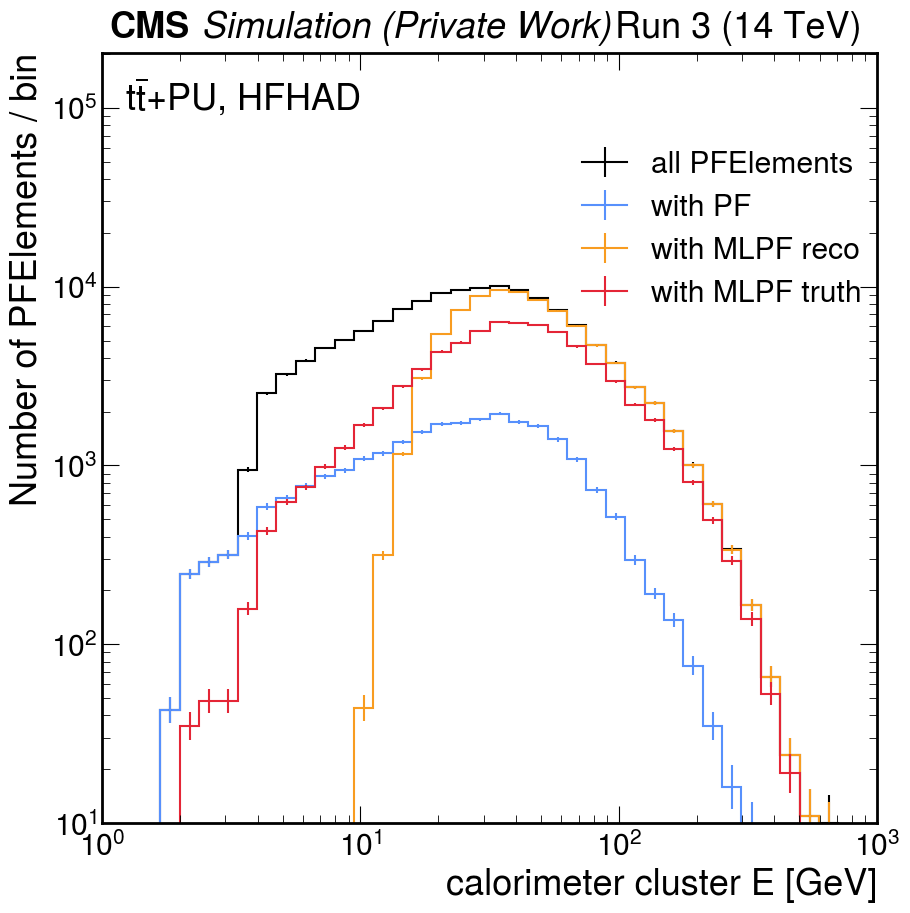

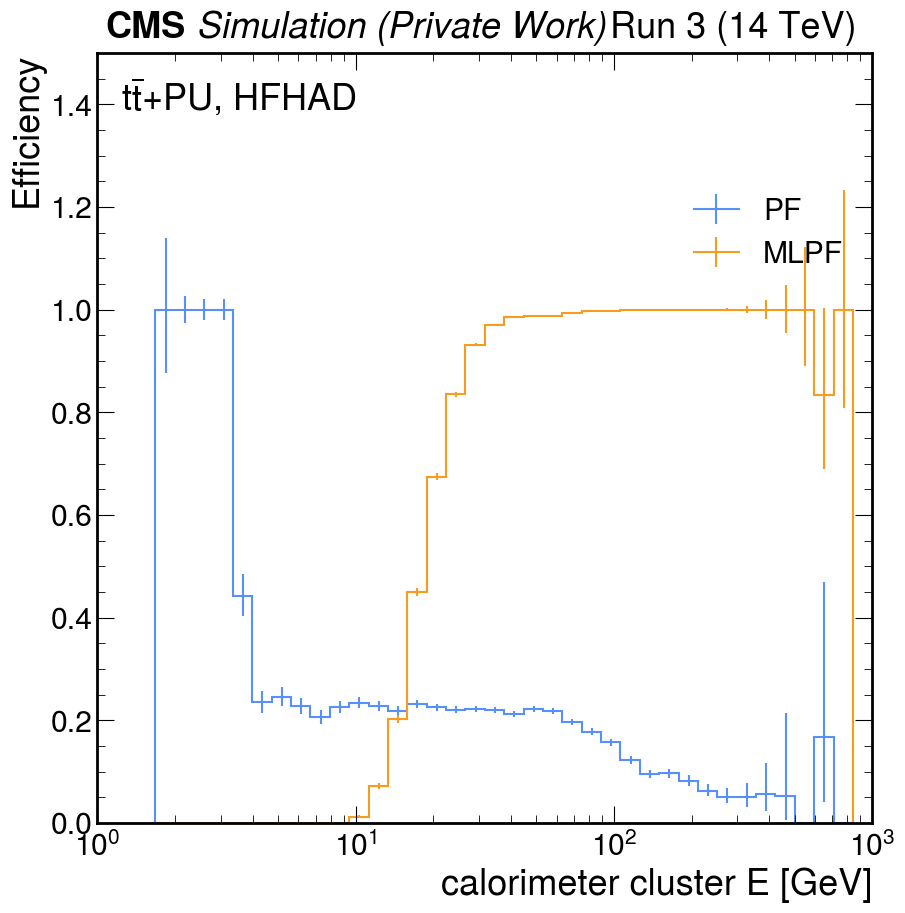

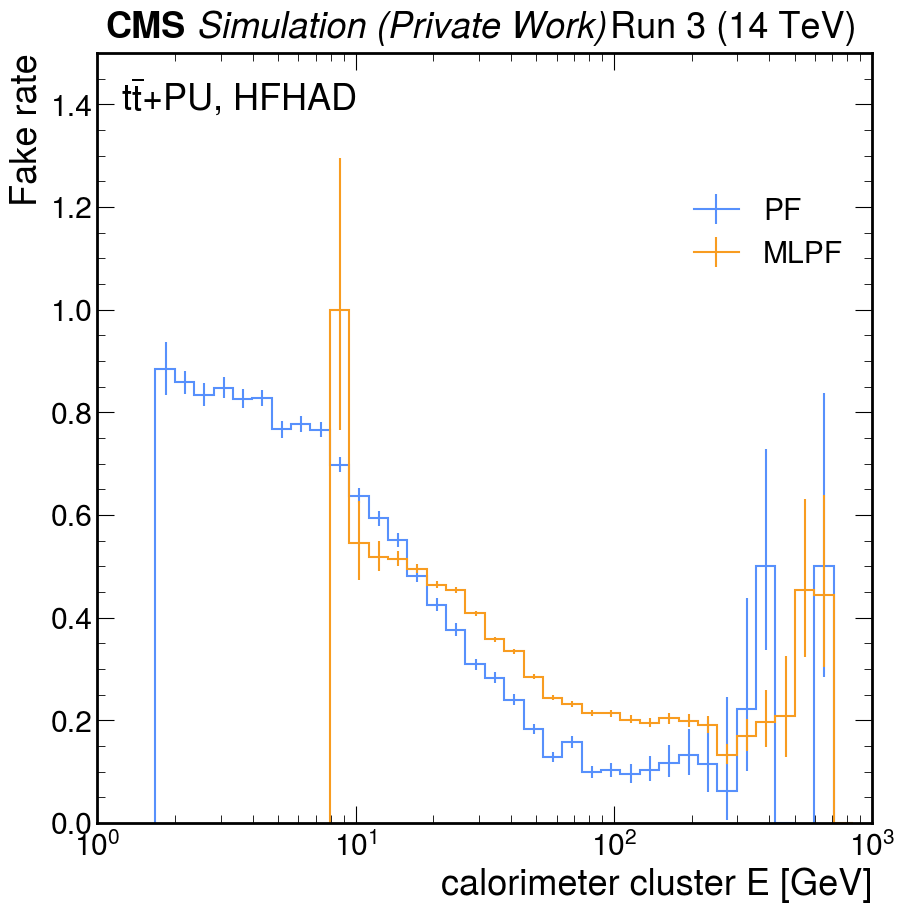

In [11]:
plot_eff_and_fake_rate(icls=3, ivar=5, ielem=9, bins=np.logspace(0, 3, 41), xlabel="calorimeter cluster E [GeV]", log=True)

/tmp/ipykernel_2439880/2089774827.py:177: RuntimeWarning: invalid value encountered in divide
  eff_mlpf.values()[:] = hist_gen_pred.values() / hist_gen.values()
/tmp/ipykernel_2439880/2089774827.py:180: RuntimeWarning: invalid value encountered in divide
  eff_pf.values()[:] = hist_gen_cand.values() / hist_gen.values()
/tmp/ipykernel_2439880/2089774827.py:183: RuntimeWarning: invalid value encountered in divide
  fake_pf.values()[:] = hist_cand_fake.values() / hist_cand.values()
/tmp/ipykernel_2439880/2089774827.py:186: RuntimeWarning: invalid value encountered in divide
  fake_mlpf.values()[:] = hist_pred_fake.values() / hist_pred.values()


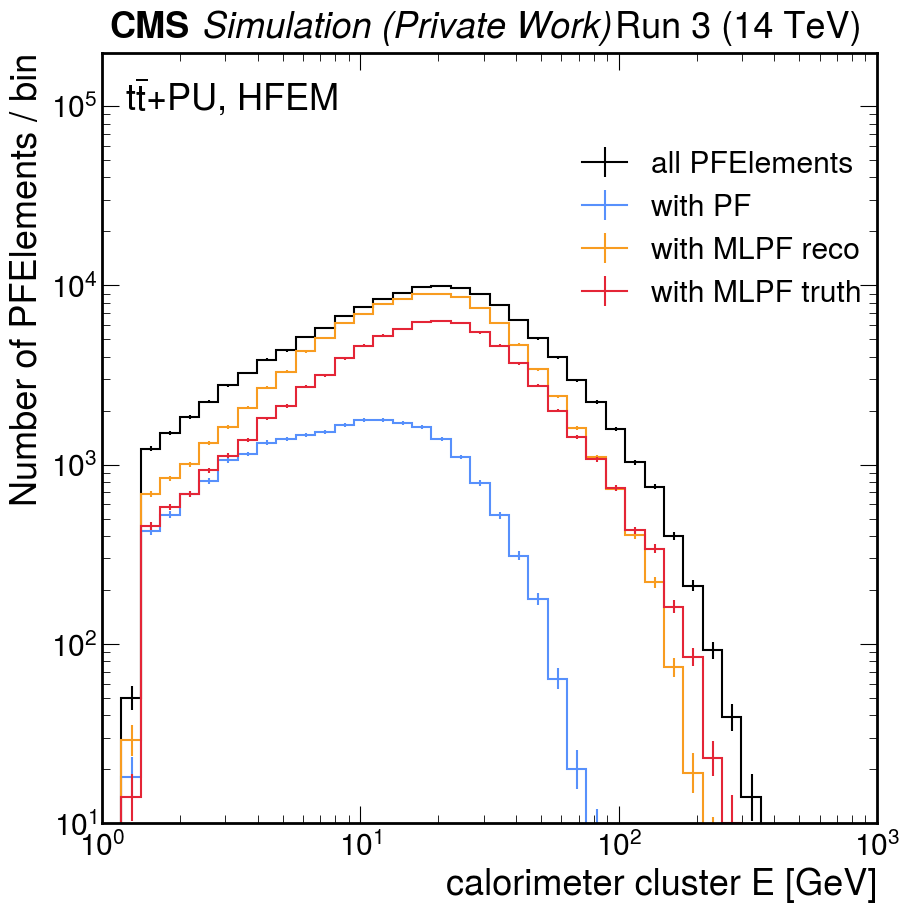

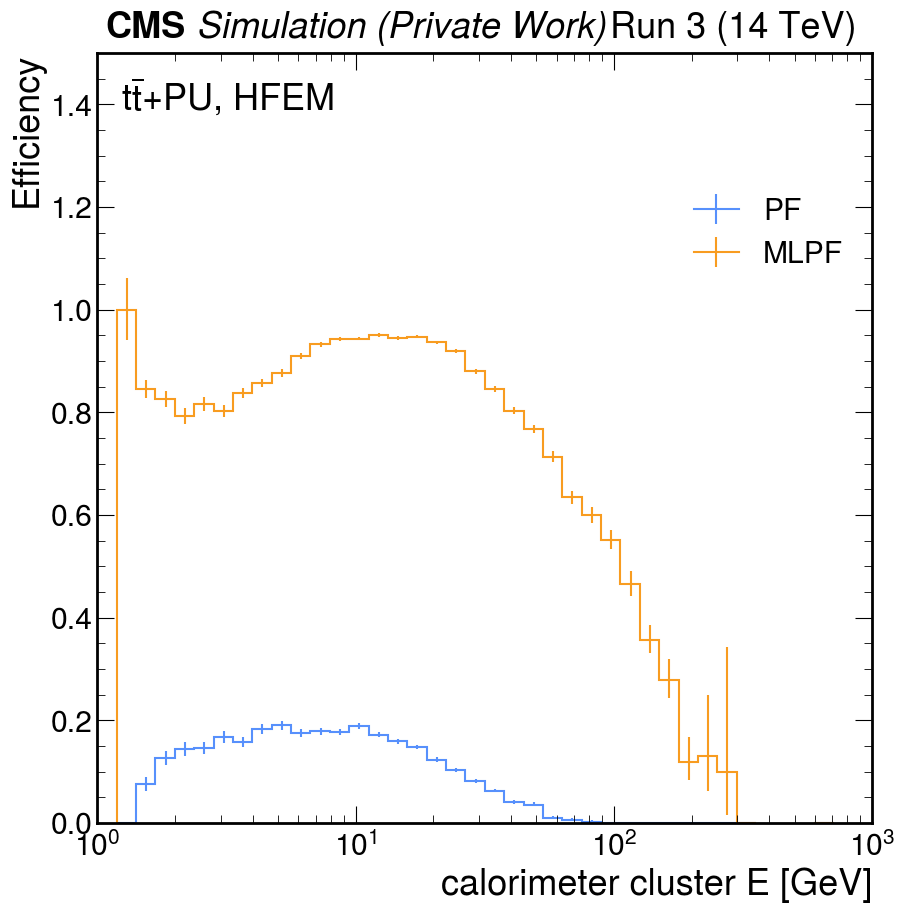

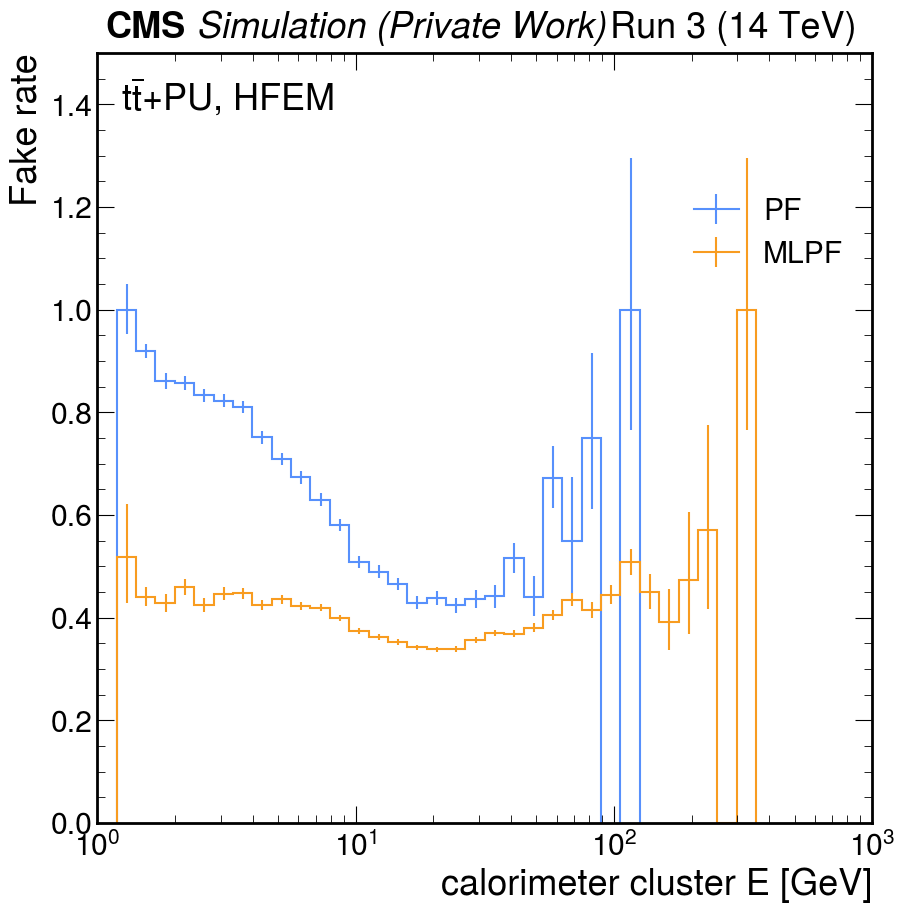

In [12]:
plot_eff_and_fake_rate(icls=4, ivar=5, ielem=8, bins=np.logspace(0, 3, 41), xlabel="calorimeter cluster E [GeV]", log=True)

In [ ]:
plot_eff_and_fake_rate(icls=5, ivar=5, ielem=4, bins=np.logspace(-1, 4, 41), xlabel="calorimeter cluster E [GeV]", log=True)

In [ ]:
plot_eff_and_fake_rate(icls=6, ivar=1, ielem=1, bins=np.logspace(0, 2, 61), xlabel="track $p_T$ [GeV]", log=True)

In [ ]:
plot_eff_and_fake_rate(icls=7, ivar=1, ielem=1, bins=np.logspace(0, 2, 61), xlabel="track $p_T$ [GeV]", log=True)

### Training details

In [ ]:
def load_history(path, min_epoch=None, max_epoch=None):
    ret = {}
    for fi in glob.glob(path):
        data = json.load(open(fi))
        data2 = {}
        for k1 in ["train", "valid"]:
            for k2 in data[k1].keys():
                data2[f"{k1}_{k2}"] = data[k1][k2]
        epoch = int(fi.split("_")[-1].split(".")[0])
        ret[epoch] = data2

    if not max_epoch:
        max_epoch = max(ret.keys())
    if not min_epoch:
        min_epoch = min(ret.keys())

    ret2 = []
    for i in range(min_epoch, max_epoch + 1):
        ret2.append(ret[i])
    
    return pandas.DataFrame(ret2)

In [ ]:
history = load_history(f"{path}/../history/epoch_*.json", max_epoch=5)

In [ ]:
history

In [ ]:
p0 = loss_plot(history.index, history["train_Total"].values, history["valid_Total"].values, margin=0.1)
plt.ylabel("Total loss")
plt.savefig("{}/loss.pdf".format(outpath), bbox_inches="tight")

In [ ]:
p0 = loss_plot(history.index, history["train_Classification"].values, history["valid_Classification"].values, margin=0.05)
#plt.ylim(0.04, 0.045)
plt.ylabel("Particle ID loss")
plt.savefig("{}/cls_loss.pdf".format(outpath), bbox_inches="tight")

In [ ]:
p0 = loss_plot(history.index, history["train_Classification_binary"].values, history["valid_Classification_binary"].values, margin=0.1)
plt.ylabel("Binary classification loss")
plt.savefig("{}/cls_bin_loss.pdf".format(outpath), bbox_inches="tight")

In [ ]:
reg_loss = sum([history["train_Regression_{}".format(l)].values for l in ["energy", "pt", "eta", "sin_phi", "cos_phi"]])
val_reg_loss = sum(
    [history["valid_Regression_{}".format(l)].values for l in ["energy", "pt", "eta", "sin_phi", "cos_phi"]]
)
p0 = loss_plot(history.index, reg_loss, val_reg_loss, margin=0.2)
plt.ylabel("Regression loss")
plt.savefig("{}/reg_loss.pdf".format(outpath), bbox_inches="tight")

### Confusion matrices

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes()

cm_norm = sklearn.metrics.confusion_matrix(
    awkward.flatten(yvals_ttbar["target_cls_id"][X_ttbar[:, :, 0] != 0]),
    awkward.flatten(yvals_ttbar["pred_cls_id"][X_ttbar[:, :, 0] != 0]),
    labels=range(0, len(CLASS_LABELS_CMS)),
    normalize="true",
)

plt.imshow(cm_norm, cmap="Blues", origin="lower")
plt.colorbar()


thresh = cm_norm.max() / 1.5
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(
        j,
        i,
        "{:0.2f}".format(cm_norm[i, j]),
        horizontalalignment="center",
        color="white" if cm_norm[i, j] > thresh else "black",
        fontsize=12,
    )

# cms_label(ax, y=1.01)
# cms_label_sample_label(x1=0.18, x2=0.52, y=0.82)
plt.xticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS, rotation=45)
plt.yticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS)
plt.xlabel("MLPF candidate ID")
plt.ylabel("Truth ID")
# plt.ylim(-0.5, 6.9)
# plt.title("MLPF trained on PF")
plt.savefig("{}/cm_normed.pdf".format(outpath), bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes()

cm_norm = sklearn.metrics.confusion_matrix(
    awkward.flatten(yvals_ttbar["target_cls_id"][X_ttbar[:, :, 0] != 0]),
    awkward.flatten(yvals_ttbar["cand_cls_id"][X_ttbar[:, :, 0] != 0]),
    labels=range(0, len(CLASS_LABELS_CMS)),
    normalize="true",
)

plt.imshow(cm_norm, cmap="Blues", origin="lower")
plt.colorbar()


thresh = cm_norm.max() / 1.5
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    plt.text(
        j,
        i,
        "{:0.2f}".format(cm_norm[i, j]),
        horizontalalignment="center",
        color="white" if cm_norm[i, j] > thresh else "black",
        fontsize=12,
    )

# cms_label(ax, y=1.01)
# cms_label_sample_label(x1=0.18, x2=0.52, y=0.82)
plt.xticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS, rotation=45)
plt.yticks(range(len(CLASS_NAMES_CMS)), CLASS_NAMES_CMS)
plt.xlabel("PF candidate ID")
plt.ylabel("Truth ID")
# plt.ylim(-0.5, 6.9)
# plt.title("MLPF trained on PF")
plt.savefig("{}/cm_normed_pf.pdf".format(outpath), bbox_inches="tight")

In [ ]:
bins = np.linspace(-5.5, 5.5, 61)

pid = 0
Nev = len(yvals_ttbar["target_eta"])

msk = yvals_ttbar["target_cls_id"] != 0
plt.hist(
    awkward.flatten(yvals_ttbar["target_eta"][msk]),
    weights=awkward.flatten(yvals_ttbar["target_energy"][msk]) / Nev,
    bins=bins,
    histtype="step",
    lw=2,
    label="gen",
)

msk = yvals_ttbar["cand_cls_id"] != 0
plt.hist(
    awkward.flatten(yvals_ttbar["cand_eta"][msk]),
    weights=awkward.flatten(yvals_ttbar["cand_energy"][msk]) / Nev,
    bins=bins,
    histtype="step",
    lw=2,
    label="PF",
)

msk = yvals_ttbar["pred_cls_id"] != 0
plt.hist(
    awkward.flatten(yvals_ttbar["pred_eta"][msk]),
    weights=awkward.flatten(yvals_ttbar["pred_energy"][msk]) / Nev,
    bins=bins,
    histtype="step",
    lw=2,
    label="MLPF",
)

plt.legend(loc="best")

In [ ]:
bins = np.linspace(-5.5, 5.5, 61)

pid = 0
msk = yvals_ttbar["target_cls_id"] != 0
plt.hist(
    awkward.flatten(yvals_ttbar["target_eta"][msk]),
    weights=awkward.flatten(yvals_ttbar["target_pt"][msk]) / Nev,
    bins=bins,
    histtype="step",
    lw=2,
    label="gen",
)

msk = yvals_ttbar["cand_cls_id"] != 0
plt.hist(
    awkward.flatten(yvals_ttbar["cand_eta"][msk]),
    weights=awkward.flatten(yvals_ttbar["cand_pt"][msk]) / Nev,
    bins=bins,
    histtype="step",
    lw=2,
    label="PF",
)

msk = yvals_ttbar["pred_cls_id"] != 0
plt.hist(
    awkward.flatten(yvals_ttbar["pred_eta"][msk]),
    weights=awkward.flatten(yvals_ttbar["pred_pt"][msk]) / Nev,
    bins=bins,
    histtype="step",
    lw=2,
    label="MLPF",
)

plt.legend(loc="best")

### Investigation into HFEM

In [28]:
import scipy

In [71]:
binary_cls = scipy.special.softmax(awkward.flatten(yvals_ttbar["pred_cls_binary"], axis=1), axis=-1)
target_cls = awkward.flatten(yvals_ttbar["target_cls_id"], axis=1)
msk_9 = awkward.flatten((X_ttbar[:, :, 0]==9), axis=1)
msk_8 = awkward.flatten((X_ttbar[:, :, 0]==8), axis=1)
X_pt = awkward.flatten(X_ttbar[:, :, 1], axis=1)

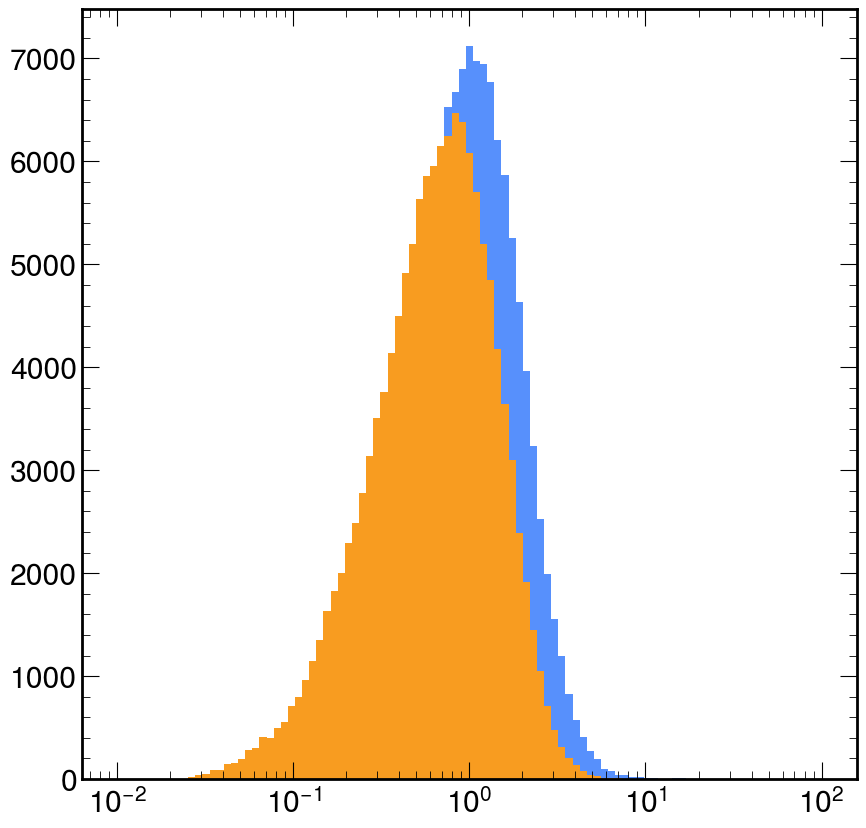

In [59]:
b = np.logspace(-2,2,100)
plt.hist(X_pt[msk_9], bins=b)
plt.hist(X_pt[msk_8], bins=b)
plt.xscale("log")

(0.0, 1.5)

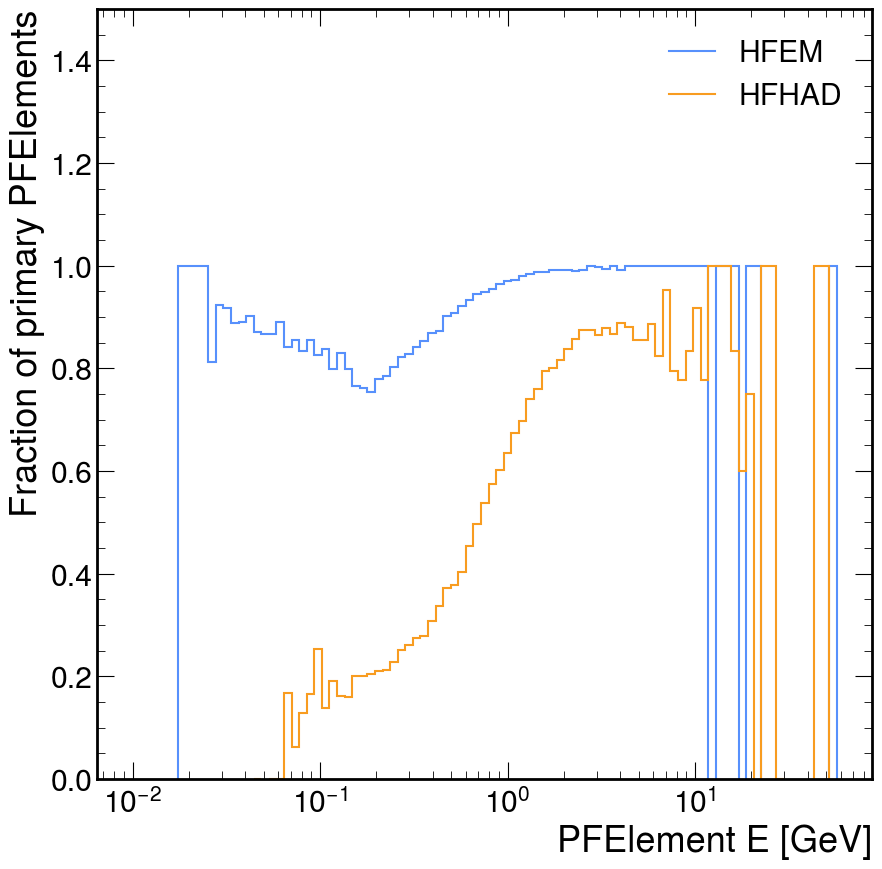

In [98]:
b = np.logspace(-2,2,100)

h_all = to_bh(
    awkward.flatten(X_ttbar[:, :, 1][(X_ttbar[:, :, 0]==8)], axis=1),
    bins=b
)

h_withtarget = to_bh(
    awkward.flatten(X_ttbar[:, :, 1][(X_ttbar[:, :, 0]==8) & (yvals_ttbar["target_cls_id"]!=0)], axis=1),
    bins=b
)

mplhep.histplot(h_withtarget/h_all, label="HFEM")
plt.xscale("log")


h_all = to_bh(
    awkward.flatten(X_ttbar[:, :, 1][(X_ttbar[:, :, 0]==9)], axis=1),
    bins=b
)

h_withtarget = to_bh(
    awkward.flatten(X_ttbar[:, :, 1][(X_ttbar[:, :, 0]==9) & (yvals_ttbar["target_cls_id"]!=0)], axis=1),
    bins=b
)

mplhep.histplot(h_withtarget/h_all, label="HFHAD")
plt.xscale("log")
plt.xlabel("PFElement E [GeV]")
plt.ylabel("Fraction of primary PFElements")
plt.legend(loc="best")
plt.ylim(0,1.5)